### ***Import required dependencies***

In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from collections import Counter
%matplotlib inline

### ***EDA***

In [3]:
df = pd.read_csv('IRIS.csv')
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
df['species']

0         Iris-setosa
1         Iris-setosa
2         Iris-setosa
3         Iris-setosa
4         Iris-setosa
            ...      
145    Iris-virginica
146    Iris-virginica
147    Iris-virginica
148    Iris-virginica
149    Iris-virginica
Name: species, Length: 150, dtype: object

In [5]:
df['species'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [6]:
df.isnull()

,sepal_length,sepal_width,petal_length,petal_width,species
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
145,False,False,False,False,False
146,False,False,False,False,False
147,False,False,False,False,False
148,False,False,False,False,False


### Data preprocessing

In [7]:
print(df)

     sepal_length  sepal_width  petal_length  petal_width         species
0             5.1          3.5           1.4          0.2     Iris-setosa
1             4.9          3.0           1.4          0.2     Iris-setosa
2             4.7          3.2           1.3          0.2     Iris-setosa
3             4.6          3.1           1.5          0.2     Iris-setosa
4             5.0          3.6           1.4          0.2     Iris-setosa
..            ...          ...           ...          ...             ...
145           6.7          3.0           5.2          2.3  Iris-virginica
146           6.3          2.5           5.0          1.9  Iris-virginica
147           6.5          3.0           5.2          2.0  Iris-virginica
148           6.2          3.4           5.4          2.3  Iris-virginica
149           5.9          3.0           5.1          1.8  Iris-virginica

[150 rows x 5 columns]


In [8]:
df['species'].replace({'Iris-versicolor': 0}, inplace=True)
df['species'].replace({'Iris-setosa': 1}, inplace=True)
df['species'].replace({'Iris-virginica': 2}, inplace=True)

In [9]:
columns_to_drop = ['species', 'petal_length', 'petal_width']
X = df.drop(columns=columns_to_drop, inplace=False)
y = df['species']

print("X (Features):")
print(X.head())
print("\ny (Target):")
print(y.head())

X (Features):
   sepal_length  sepal_width
0           5.1          3.5
1           4.9          3.0
2           4.7          3.2
3           4.6          3.1
4           5.0          3.6

y (Target):
0    1
1    1
2    1
3    1
4    1
Name: species, dtype: int64


In [10]:
X.shape

(150, 2)

In [11]:
y.shape

(150,)

In [12]:
y.unique()

array([1, 0, 2], dtype=int64)

### K-mean clustering

In [13]:
def l1_distance(X_i, X_j):
    distance = 0
    for i in range(len(X_i)):
        distance += abs(X_i[i] - X_j[i])
    return distance

In [14]:
def l1_distance_numpy(X_i, X_j):
    return np.sum(np.abs(X_i - X_j))

In [15]:
def select_centroids_randomly(X, n, k):
    result = []
    for obj_id in np.random.randint(0, n, size=k):
        result.append(X[obj_id, :])
    return result

In [16]:
def evaluate_weight_progress(centroid_objects_prev, centroid_objects, k):
    """Calculate how the centers moved in one step of the algorithm"""
    result = []
    for i in range(k):
        dist = l1_distance_numpy(centroid_objects_prev[i],
                                 centroid_objects[i])
        result.append(dist)
    return result

In [17]:
def evaluate_cluster_labels(X, centroid_objects):
    """Calculate cluster labels."""
    # Calculate the number of data points and centroids
    n_samples = X.shape[0]
    n_centroids = centroid_objects.shape[0]
    
    # Initialize array to store distances
    distances = np.zeros((n_samples, n_centroids))
    
    # Calculate distances between each data point and each centroid using L1 distance
    for i in range(n_samples):
        for j in range(n_centroids):
            distances[i, j] = l1_distance_numpy(X[i], centroid_objects[j])
    
    # Find the index of the closest centroid for each data point
    cluster_labels = np.argmin(distances, axis=1)
    
    return cluster_labels

In [18]:
def evaluate_centroids(X, k, cluster_lables):
    """Calculate new centroids using the coordinate averaging method."""
    result = []
    for i in range(k):
        new_centroid = X[cluster_lables == i].mean(axis=0)
        result.append(new_centroid)
    return result

In [19]:
def calculate_inertia(X, centroids, cluster_labels):
    """Calculate inertia (total within-cluster sum of squares)."""
    inertia = 0
    for i, centroid in enumerate(centroids):
        cluster_points = X[cluster_labels == i]
        cluster_inertia = np.sum((cluster_points - centroid) ** 2)
        inertia += cluster_inertia
    return inertia

In [20]:
def plot_inertia(inertia_values):
    """Plot inertia values over iterations."""
    plt.plot(range(1, len(inertia_values) + 1), inertia_values, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Inertia (Total Within-Cluster Sum of Squares)')
    plt.title('Change in Inertia Over Iterations')
    plt.grid(True)
    plt.show()

In [21]:
def k_means(X: np.array, k: int = 2, eps: float = 0.001, num_iteration: int = 10) -> np.array:
    """K-means algorithm

    :param X: training data
    :param k: number of clusters
    """
    try:
        n, m = X.shape
    except ValueError:
        print("The training sample must be a two-dimensional array (n, m) where m is the sample size")
    # initialize the centroids with a random sample element
    centroid_objects = select_centroids_randomly(X, n, k)
    centroid_objects_prev = [np.zeros(m) for i in range(k)]
    # distance between the previous and current position of each centroid
    weight_evolution = evaluate_weight_progress(centroid_objects_prev, centroid_objects, k)
    step = 0
    # stop condition: the centroids have not changed their position
    # repeat until the stop condition is met
    inertia_values = []
    while sum(weight_evolution[i] > eps for i in range(k)) != 0 and step < num_iteration:
        centroid_objects_prev = centroid_objects.copy()
        # calculate cluster labels
        cluster_labels = evaluate_cluster_labels(X, np.array(centroid_objects))
        # average the coordinates of objects in each cluster - this is the new position of the centroid
        centroid_objects = evaluate_centroids(X, k, cluster_labels)
        # calculate the distance between centroids at adjacent iterations
        weight_evolution = evaluate_weight_progress(centroid_objects_prev, centroid_objects, k)
        print("шаг %s, смещение кластеров: %s" % (step, weight_evolution))
        inertia = calculate_inertia(X, centroid_objects, cluster_labels)
        inertia_values.append(inertia)
        # update clusters
        step += 1
    return np.vstack(centroid_objects), cluster_labels, inertia_values

In [22]:
centroids, cluster_labels,inertia_values = k_means(X.values, k=3)

шаг 0, смещение кластеров: [0.710447761194029, 0.7897058823529388, 0.5133333333333336]
шаг 1, смещение кластеров: [0.013003165988240806, 0.06246803069053675, 0.32000000000000073]
шаг 2, смещение кластеров: [0.046920019870838825, 0.014637681159419547, 0.1771929824561389]
шаг 3, смещение кластеров: [0.05708430913348872, 0.0, 0.11030701754386074]
шаг 4, смещение кластеров: [0.09757142857142975, 0.0, 0.13916666666666622]
шаг 5, смещение кластеров: [0.026833333333331932, 0.0, 0.03062500000000057]
шаг 6, смещение кластеров: [0.10939922480620279, 0.0, 0.12559121621621605]
шаг 7, смещение кластеров: [0.17952353942144095, 0.052985074626865636, 0.09092664092664116]
шаг 8, смещение кластеров: [0.19024390243902323, 0.013681592039799906, 0.1116071428571428]
шаг 9, смещение кластеров: [0.06944444444444509, 0.018717948717949184, 0.024107142857142883]


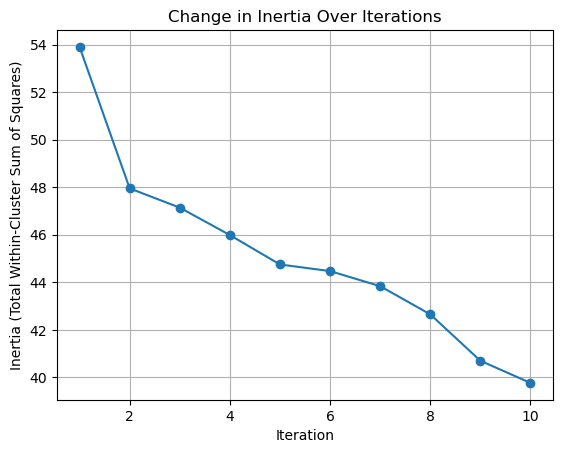

In [23]:
plot_inertia(inertia_values)

In [24]:
centroids

array([[5.56666667, 2.59722222],
       [6.62      , 3.01538462],
       [5.01632653, 3.44081633]])

In [25]:
cluster_labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

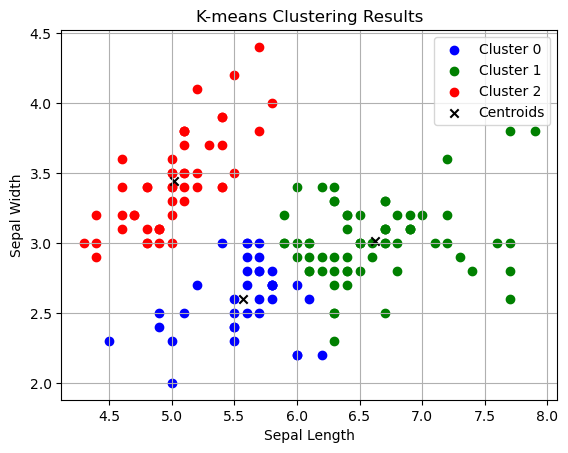

In [26]:
def plot_clusters(X, centroids, cluster_labels):
    """Plot data points with centroids and cluster labels."""
    # Define colors for each cluster
    colors = ['b', 'g', 'r']

    # Create a scatter plot for each cluster
    for cluster_id in range(len(centroids)):
        plt.scatter(X[cluster_labels == cluster_id, 0], X[cluster_labels == cluster_id, 1], color=colors[cluster_id], label=f'Cluster {cluster_id}')

    # Plot centroids
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='black', label='Centroids')

    # Add labels and legend
    plt.xlabel('Sepal Length')
    plt.ylabel('Sepal Width')
    plt.title('K-means Clustering Results')
    plt.legend()

    # Show plot
    plt.grid(True)
    plt.show()

plot_clusters(X.values, centroids, cluster_labels)

In [27]:
def assign_cluster_labels(cluster_labels, true_labels):
    """Assign class labels to clusters based on majority class."""
    cluster_to_class = {}
    for cluster_id in np.unique(cluster_labels):
        # Extract true labels corresponding to data points in the cluster
        cluster_true_labels = true_labels[cluster_labels == cluster_id]
        # Find the majority class in the cluster
        majority_class = Counter(cluster_true_labels).most_common(1)[0][0]
        cluster_to_class[cluster_id] = majority_class
    # Assign class labels to clusters
    assigned_labels = np.array([cluster_to_class[label] for label in cluster_labels])
    return assigned_labels

def calculate_accuracy(predicted_labels, true_labels):
    """Calculate accuracy of the classifier."""
    return np.mean(predicted_labels == true_labels)


# Assign class labels to clusters
predicted_labels = assign_cluster_labels(cluster_labels, y)

# Calculate accuracy
accuracy = calculate_accuracy(predicted_labels, y)
print("Accuracy of the prototype-based classifier:", accuracy)

Accuracy of the prototype-based classifier: 0.7866666666666666
